[[0 1 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [2 0 0 0]]
Accuracy: 0.00


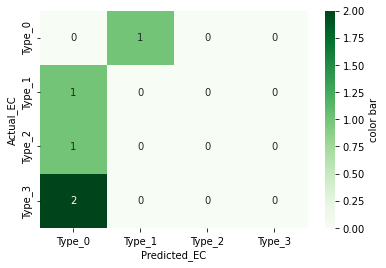

K cross validation:
Accuracy: 0.00 %
Standard Deviation: 0.00 %
[[0.25 0.25 0.25 0.25]]
[0]


/home/kushal/.local/lib/python3.10/site-packages/impedance/visualization.py:39: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(np.real(Z), -np.imag(Z), fmt, **kwargs)
/home/kushal/.local/lib/python3.10/site-packages/impedance/visualization.py:39: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".-" (-> marker='.'). The keyword argument will take precedence.
  ax.plot(np.real(Z), -np.imag(Z), fmt, **kwargs)
/home/kushal/.local/lib/python3.10/site-packages/impedance/visualization.py:39: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(np.real(Z), -np.imag(Z), fmt, **kwargs)
/home/kushal/.local/lib/python3.10/site-packages/impedance/visualization.py:39: UserWarning: marker is redundant

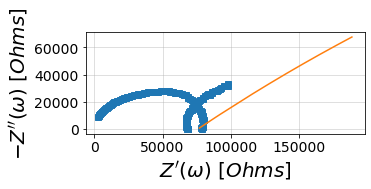

Circuit Type [0]

Circuit string: R_0-p(CPE_1,R_1-p(CPE_2,R_2-Wo_1))
Fit: True

Initial guesses:
    R_0 = 9.00e+04 [Ohm]
  CPE_1_0 = 4.52e-08 [Ohm^-1 sec^a]
  CPE_1_1 = 4.00e-01 []
    R_1 = 1.49e+06 [Ohm]
  CPE_2_0 = 3.00e-07 [Ohm^-1 sec^a]
  CPE_2_1 = 4.00e-01 []
    R_2 = 5.00e+07 [Ohm]
  Wo_1_0 = 5.00e+09 [Ohm]
  Wo_1_1 = 8.00e+04 [sec]

Fit parameters:
    R_0 = 7.56e+04  (+/- 7.34e+03) [Ohm]
  CPE_1_0 = 1.68e-06  (+/- 1.76e-06) [Ohm^-1 sec^a]
  CPE_1_1 = 3.76e-01  (+/- 1.61e-01) []
    R_1 = 1.42e+06  (+/- 5.11e-01) [Ohm]
  CPE_2_0 = 7.67e-05  (+/- 3.84e-01) [Ohm^-1 sec^a]
  CPE_2_1 = 4.27e-01  (+/- 1.76e+03) []
    R_2 = 5.07e+09  (+/- 0.00e+00) [Ohm]
  Wo_1_0 = 1.50e+10  (+/- 0.00e+00) [Ohm]
  Wo_1_1 = 5.87e+04  (+/- 0.00e+00) [sec]



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from impedance import preprocessing
from impedance.models.circuits import CustomCircuit

# Load and prepare the dataset
dataset = pd.read_csv(r"Book1.csv")
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Scale the features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Train the classifier
classifier = DecisionTreeClassifier(criterion='gini', random_state=0)
classifier.fit(X_train, y_train)

# Evaluate the classifier
y_pred = classifier.predict(X_test)
cm1 = confusion_matrix(y_test, y_pred)
print(cm1)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Plot the confusion matrix
sns.heatmap(cm1, cmap="Greens", annot=True, cbar_kws={"label": "color bar"},
            xticklabels=["Type_0", "Type_1", "Type_2", "Type_3"], yticklabels=["Type_0", "Type_1", "Type_2", "Type_3"])
plt.xlabel("Predicted_EC")
plt.ylabel("Actual_EC")
plt.show()

# Perform cross-validation
accuracies = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=3)
print("K cross validation:")
print(f"Accuracy: {accuracies.mean() * 100:.2f} %")
print(f"Standard Deviation: {accuracies.std() * 100:.2f} %")

# Load and interpolate new data
input_csv = r"50.csv"
df = pd.read_csv(input_csv)
new_data_points = 181
interpolated_df = pd.DataFrame()

for column in df.columns:
    x = np.linspace(0, len(df[column]) - 1, len(df[column]))
    x_new = np.linspace(0, len(df[column]) - 1, new_data_points)
    y = df[column].values
    y_interp = np.interp(x_new, x, y)
    interpolated_df[column] = y_interp

output_csv = r'Interpolated 1.5 Bias.csv'
interpolated_df.to_csv(output_csv, index=False)

# Transpose and flatten the interpolated data
interpolated_data = pd.read_csv(output_csv)
transposed_data = interpolated_data.transpose()
flattened_data = pd.concat([pd.Series(transposed_data.values.flatten())], ignore_index=True)

# Save the flattened data
output_csv = r'Concatinated 1.5 Bias.csv'
flattened_data.to_csv(output_csv, index=False, header=False)

# Load the flattened new input data
new_input = pd.read_csv(r"Concatinated 1.5 Bias.csv", header=None).T

# Ensure the new input data has the correct shape
new_input = new_input.values
new_input = sc.transform(new_input)

# Predict probabilities and classes
class_probs = classifier.predict_proba(new_input)
print(class_probs)

prediction = classifier.predict(new_input)
print(prediction)

# Handle predictions and plot Nyquist plots
def objective_function(params, frequencies, Z, circuit_str):
    customCircuit = CustomCircuit(initial_guess=params, circuit=circuit_str)
    customCircuit.fit(frequencies, Z)
    residuals = np.abs(customCircuit.predict(frequencies) - Z)
    return np.sum(residuals ** 2)

# Set a threshold for the fitting error
if prediction == 0 :
  frequencies, Z = preprocessing.readCSV(r"30.csv")
  frequencies, Z = preprocessing.ignoreBelowX(frequencies, Z)
  customCircuit = CustomCircuit(initial_guess=[9.0e+04, 4.52e-08 , 4.0e-01, 1.49e+06, 3.0e-07, 4.0e-01, 5.0e+07, 5.0e+09, 8.0e+04],
                                circuit='R_0 - p(CPE_1, R_1 - p(CPE_2, R_2 - Wo_1))')
  customCircuit.fit(frequencies, Z)
  customCircuit.plot(f_data=frequencies, Z_data=Z, kind='nyquist')
  plt.show()
  print('Circuit Type', prediction)
  print(customCircuit)
elif prediction == 1 :
  frequencies, Z = preprocessing.readCSV(r"30.csv")
  frequencies, Z = preprocessing.ignoreBelowX(frequencies, Z)
  customCircuit = CustomCircuit(initial_guess=[7.0e+04, 7.0e+04, 1.0e-06, 2.50e-01, 1.0e+05  , 2.0e-09,  8.0e-01],
                                circuit='R_0-p(R_1,CPE_1)-p(R_2,CPE_2)')
  customCircuit.fit(frequencies, Z)
  customCircuit.plot(f_data=frequencies, Z_data=Z, kind='nyquist')
  plt.show()
  print('Circuit Type', prediction)
  print(customCircuit)
elif prediction == 2 :
  frequencies, Z = preprocessing.readCSV(r"30.csv")
  frequencies, Z = preprocessing.ignoreBelowX(frequencies, Z)
  customCircuit = CustomCircuit(initial_guess=[1.0e+05, 2.0e+05, 5.0e-09, 7.0e-01],
                                circuit='R_0-p(R_1,CPE_1)')
  customCircuit.fit(frequencies, Z)
  customCircuit.plot(f_data=frequencies, Z_data=Z, kind='nyquist')
  plt.show()
  print('Circuit Type', prediction)
  print(customCircuit)
else :
  frequencies, Z = preprocessing.readCSV(r"30.csv")
  frequencies, Z = preprocessing.ignoreBelowX(frequencies, Z)
  customCircuit = CustomCircuit(initial_guess=[7.0e+04, 7.0e+04, 1.02e-06, 2.50e-01, 1.0e+05  , 2.0e-09,  8.0e-01],
                                circuit='R_0 - p(CPE_1,R_1) - p(CPE_2,R_2 - p(L_3, R_3))')
  tolerance = 1e-6  # Define a fitting tolerance
  previous_fit_error = np.inf
  max_iterations = 1000
  iteration = 0

  while iteration < max_iterations:
      result = minimize(objective_function, initial_guess, args=(frequencies, Z, circuit_str), method='Nelder-Mead')
      customCircuit = CustomCircuit(initial_guess=result.x, circuit=circuit_str)
      customCircuit.fit(frequencies, Z)
      fit_error = objective_function(result.x, frequencies, Z, circuit_str)
      
      # Check if the improvement is within the tolerance
      if abs(previous_fit_error - fit_error) < tolerance:
          break
      
      previous_fit_error = fit_error
      iteration += 1
      initial_guess = result.x  # Update initial guess for next iteration

  # Fit and plot the optimized circuit
  fit_and_plot_circuit(frequencies, Z, result.x, circuit_str)

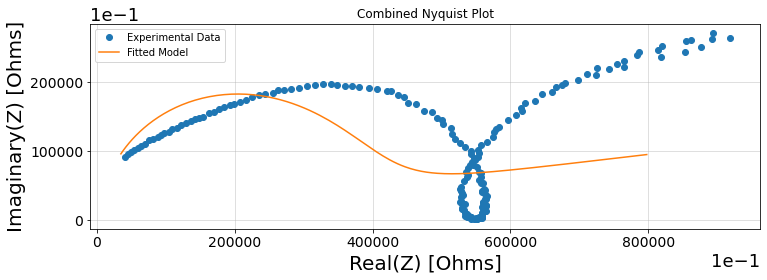

Fitted Parameters: [7.59283565e+01 1.35066708e-07 2.59505446e-02 1.63837277e+02
 9.24908178e-06 7.58503612e-02 1.61854167e+02 9.85516642e+01
 1.41484146e-09]


<Figure size 432x288 with 0 Axes>

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from impedance import preprocessing
from impedance.models.circuits import CustomCircuit
from impedance.visualization import plot_nyquist

# Function to clean data (removing NaNs and Infs)
def clean_data(frequencies, Z):
    mask = ~np.isnan(Z) & ~np.isinf(Z)
    return frequencies[mask], Z[mask]

frequencies, Z = preprocessing.readCSV('50.csv')

frequencies, Z = clean_data(frequencies, Z)


circuit_str = 'R0-p(CPE1,R1-p(CPE2,R2-Wo1))'
initial_guess = [1, 1e-7, 0.85, 1e2, 1e-7, 0.8, 1e2, 1e-3, 0.00005]  # Adjusted initial guesses

circuit = CustomCircuit(circuit=circuit_str, initial_guess=initial_guess)


circuit.fit(frequencies, Z)

# Predict the fitted data
Z_fit = circuit.predict(frequencies)

# Combine both graphs in one
plt.figure(figsize=(12, 8))  # Bigger graph for better visualization


plot_nyquist(Z, fmt='o', scale=10, ax=plt.gca(), label='Experimental Data')

plot_nyquist(Z_fit, fmt='-', scale=10, ax=plt.gca(), label='Fitted Model')

plt.legend()
plt.title('Combined Nyquist Plot')
plt.xlabel('Real(Z) [Ohms]')
plt.ylabel('Imaginary(Z) [Ohms]')
plt.grid(True)
plt.show()


print("Fitted Parameters:", circuit.parameters_)


np.savetxt('fitted_parameters.csv', circuit.parameters_, delimiter=',', 
           header='R0,CPE1_Q,CPE1_alpha,R1,CPE2_Q,CPE2_alpha,R2,Wo1_0,Wo1_1', 
           comments='')


plt.savefig('combined_nyquist_plot.png', dpi=300)


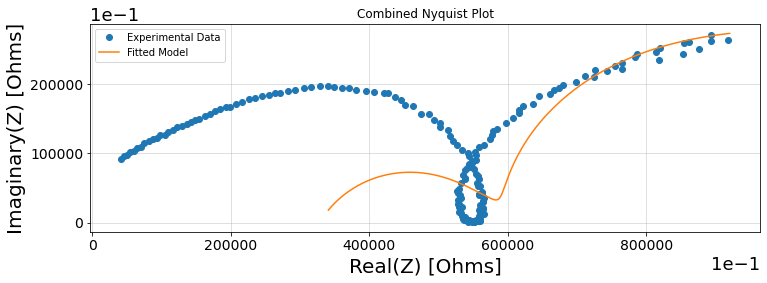

Fitted Parameters: [3.27934460e+04 1.47136143e-08 6.56994921e-01 2.17873325e+04
 8.78449157e-06 1.85841564e-01 4.61927368e+03 5.91208343e+03
 9.66566489e-04]


<Figure size 432x288 with 0 Axes>

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from impedance import preprocessing
from impedance.models.circuits import CustomCircuit
from impedance.visualization import plot_nyquist

# Function to clean data (removing NaNs and Infs)
def clean_data(frequencies, Z):
    mask = ~np.isnan(Z) & ~np.isinf(Z)
    return frequencies[mask], Z[mask]

frequencies, Z = preprocessing.readCSV('50.csv')

frequencies, Z = clean_data(frequencies, Z)


circuit_str = 'R0-p(CPE1,R1-p(CPE2,R2-Wo1))'
initial_guess = [1.59283565e+01, .35066708e-06, 10.59505446e-06, 10.63837277e+01,  90.24908178e-05, 7.58503612e-02, 2.61854167e+02, 1.85516642e+03, 4.41484146e-02 ]  # Adjusted initial guesses

circuit = CustomCircuit(circuit=circuit_str, initial_guess=initial_guess)


circuit.fit(frequencies, Z)

# Predict the fitted data
Z_fit = circuit.predict(frequencies)

# Combine both graphs in one
plt.figure(figsize=(12, 8))  # Bigger graph for better visualization


plot_nyquist(Z, fmt='o', scale=10, ax=plt.gca(), label='Experimental Data')

plot_nyquist(Z_fit, fmt='-', scale=10, ax=plt.gca(), label='Fitted Model')

plt.legend()
plt.title('Combined Nyquist Plot')
plt.xlabel('Real(Z) [Ohms]')
plt.ylabel('Imaginary(Z) [Ohms]')
plt.grid(True)
plt.show()


print("Fitted Parameters:", circuit.parameters_)


np.savetxt('fitted_parameters.csv', circuit.parameters_, delimiter=',', 
           header='R0,CPE1_Q,CPE1_alpha,R1,CPE2_Q,CPE2_alpha,R2,Wo1_0,Wo1_1', 
           comments='')


plt.savefig('combined_nyquist_plot.png', dpi=300)


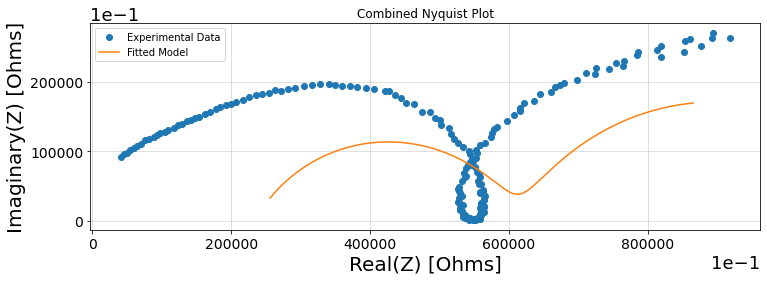

Fitted Parameters: [2.34250451e+04 5.68381871e-09 6.80968633e-01 3.79006599e+04
 1.56163981e-06 6.82719402e-01 4.77644640e+04 1.58523127e+04
 9.58701063e+03]


<Figure size 432x288 with 0 Axes>

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from impedance import preprocessing
from impedance.models.circuits import CustomCircuit
from impedance.visualization import plot_nyquist

# Function to clean data (removing NaNs and Infs)
def clean_data(frequencies, Z):
    mask = ~np.isnan(Z) & ~np.isinf(Z)
    return frequencies[mask], Z[mask]

frequencies, Z = preprocessing.readCSV('50.csv')

frequencies, Z = clean_data(frequencies, Z)


circuit_str = 'R_0 - p(CPE_1,R_1) - p(CPE_2,R_2 - p(L_3, R_3))'
initial_guess = [1.59283565e+01, .35066708e-06, 10.59505446e-06, 5.63837277e+01,  85.24908178e-05, 70.58503612e-02, 2.61854167e+02, 1.85516642e+03, 4.41484146e-02 ]  # Adjusted initial guesses

circuit = CustomCircuit(circuit=circuit_str, initial_guess=initial_guess)


circuit.fit(frequencies, Z)

# Predict the fitted data
Z_fit = circuit.predict(frequencies)

# Combine both graphs in one
plt.figure(figsize=(12, 8))  # Bigger graph for better visualization


plot_nyquist(Z, fmt='o', scale=10, ax=plt.gca(), label='Experimental Data')

plot_nyquist(Z_fit, fmt='-', scale=10, ax=plt.gca(), label='Fitted Model')

plt.legend()
plt.title('Combined Nyquist Plot')
plt.xlabel('Real(Z) [Ohms]')
plt.ylabel('Imaginary(Z) [Ohms]')
plt.grid(True)
plt.show()


print("Fitted Parameters:", circuit.parameters_)


np.savetxt('fitted_parameters.csv', circuit.parameters_, delimiter=',', 
           header='R0,CPE1_Q,CPE1_alpha,R1,CPE2_Q,CPE2_alpha,R2,Wo1_0,Wo1_1', 
           comments='')


plt.savefig('combined_nyquist_plot.png', dpi=300)


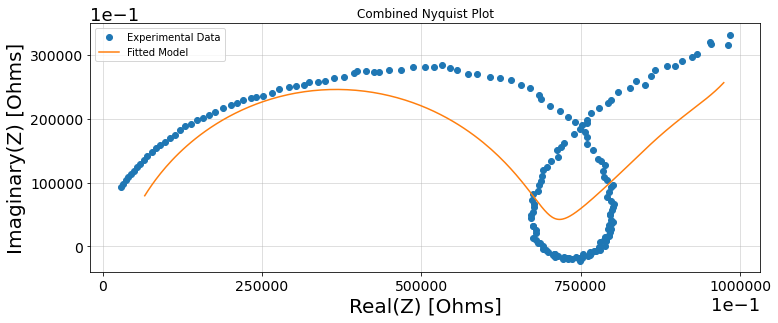

Fitted Parameters: [2.96117405e+03 3.67859010e-10 8.04974008e-01 6.47382284e+04
 4.17396643e-07 2.90165458e-01 2.16039730e+03 1.07837056e+05
 1.52629078e-01]


<Figure size 432x288 with 0 Axes>

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from impedance import preprocessing
from impedance.models.circuits import CustomCircuit
from impedance.visualization import plot_nyquist

# Function to clean data (removing NaNs and Infs)
def clean_data(frequencies, Z):
    mask = ~np.isnan(Z) & ~np.isinf(Z)
    return frequencies[mask], Z[mask]

frequencies, Z = preprocessing.readCSV('30.csv')

frequencies, Z = clean_data(frequencies, Z)


circuit_str = 'R0-p(CPE1,R1-p(CPE2,R2-Wo1))'
initial_guess = [ 2.76430581e+03 ,3.90392785e-10 ,7.98069621e-01 ,3.89854122e+04 ,2.72868233e-07 ,2.62302805e-01 ,1.02306357e+04 ,1.14769552e+05 ,1.22903343e-01 ]  # Adjusted initial guesses

circuit = CustomCircuit(circuit=circuit_str, initial_guess=initial_guess)


circuit.fit(frequencies, Z)

# Predict the fitted data
Z_fit = circuit.predict(frequencies)

# Combine both graphs in one
plt.figure(figsize=(12, 8))  # Bigger graph for better visualization


plot_nyquist(Z, fmt='o', scale=10, ax=plt.gca(), label='Experimental Data')

plot_nyquist(Z_fit, fmt='-', scale=10, ax=plt.gca(), label='Fitted Model')

plt.legend()
plt.title('Combined Nyquist Plot')
plt.xlabel('Real(Z) [Ohms]')
plt.ylabel('Imaginary(Z) [Ohms]')
plt.grid(True)
plt.show()


print("Fitted Parameters:", circuit.parameters_)


np.savetxt('fitted_parameters.csv', circuit.parameters_, delimiter=',', 
           header='R0,CPE1_Q,CPE1_alpha,R1,CPE2_Q,CPE2_alpha,R2,Wo1_0,Wo1_1', 
           comments='')


plt.savefig('combined_nyquist_plot.png', dpi=300)


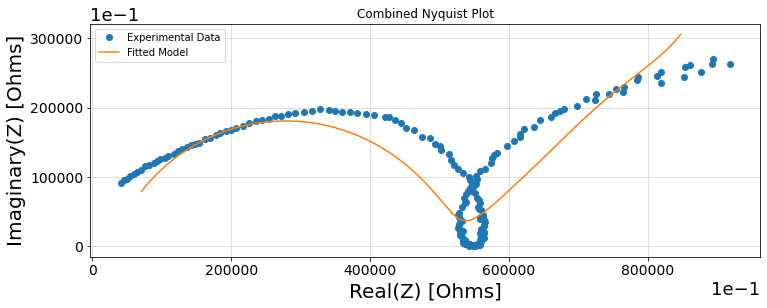

Fitted Parameters: [2.88713872e+03 3.72005215e-10 8.01026231e-01 4.88833762e+04
 2.69323527e-07 2.57638297e-01 4.75633564e+02 1.20866891e+05
 1.38768647e-01]


<Figure size 432x288 with 0 Axes>

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from impedance import preprocessing
from impedance.models.circuits import CustomCircuit
from impedance.visualization import plot_nyquist

# Function to clean data (removing NaNs and Infs)
def clean_data(frequencies, Z):
    mask = ~np.isnan(Z) & ~np.isinf(Z)
    return frequencies[mask], Z[mask]

frequencies, Z = preprocessing.readCSV('50.csv')

frequencies, Z = clean_data(frequencies, Z)


circuit_str = 'R0-p(CPE1,R1-p(CPE2,R2-Wo1))'
initial_guess = [2.88713872e+03 ,3.72005215e-10 ,8.01026231e-01 ,4.88833762e+04, 2.69323527e-07 ,2.57638297e-01 ,4.75633564e+02 ,1.20866891e+05 ,1.38768647e-01]  # Adjusted initial guesses

circuit = CustomCircuit(circuit=circuit_str, initial_guess=initial_guess)


circuit.fit(frequencies, Z)

# Predict the fitted data
Z_fit = circuit.predict(frequencies)

# Combine both graphs in one
plt.figure(figsize=(12, 8))  # Bigger graph for better visualization


plot_nyquist(Z, fmt='o', scale=10, ax=plt.gca(), label='Experimental Data')

plot_nyquist(Z_fit, fmt='-', scale=10, ax=plt.gca(), label='Fitted Model')

plt.legend()
plt.title('Combined Nyquist Plot')
plt.xlabel('Real(Z) [Ohms]')
plt.ylabel('Imaginary(Z) [Ohms]')
plt.grid(True)
plt.show()


print("Fitted Parameters:", circuit.parameters_)


np.savetxt('fitted_parameters.csv', circuit.parameters_, delimiter=',', 
           header='R0,CPE1_Q,CPE1_alpha,R1,CPE2_Q,CPE2_alpha,R2,Wo1_0,Wo1_1', 
           comments='')


plt.savefig('combined_nyquist_plot.png', dpi=300)


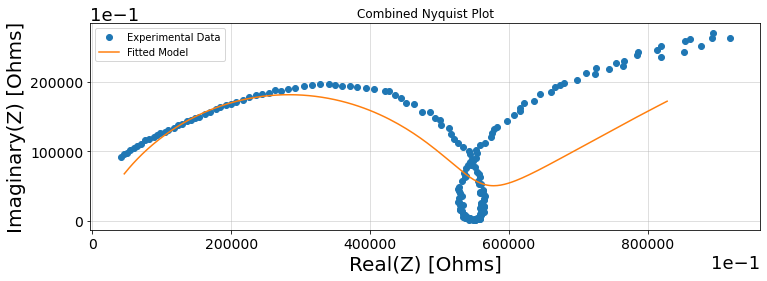

Fitted Parameters: [3.41496500e+02 1.09204944e-09 7.43884442e-01 5.28066010e+04
 6.98454738e-06 3.59878844e-01 2.65004455e+05 6.75767880e+04
 2.02756599e+05]


<Figure size 432x288 with 0 Axes>

In [3]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from impedance import preprocessing
from impedance.models.circuits import CustomCircuit
from impedance.visualization import plot_nyquist

# Function to clean data (removing NaNs and Infs)
def clean_data(frequencies, Z):
    mask = ~np.isnan(Z) & ~np.isinf(Z)
    return frequencies[mask], Z[mask]

frequencies, Z = preprocessing.readCSV('50.csv')

frequencies, Z = clean_data(frequencies, Z)


circuit_str = 'R_0 - p(CPE_1,R_1) - p(CPE_2,R_2 - p(L_3, R_3))'
initial_guess = [2.88713872e+03 ,3.72005215e-10 ,8.01026231e-01 ,4.88833762e+04, 2.69323527e-07 ,2.57638297e-01 ,4.75633564e+02 ,1.20866891e+05 ,1.38768647e-01]  # Adjusted initial guesses

circuit = CustomCircuit(circuit=circuit_str, initial_guess=initial_guess)


circuit.fit(frequencies, Z)

# Predict the fitted data
Z_fit = circuit.predict(frequencies)

# Combine both graphs in one
plt.figure(figsize=(12, 8))  # Bigger graph for better visualization


plot_nyquist(Z, fmt='o', scale=10, ax=plt.gca(), label='Experimental Data')

plot_nyquist(Z_fit, fmt='-', scale=10, ax=plt.gca(), label='Fitted Model')

plt.legend()
plt.title('Combined Nyquist Plot')
plt.xlabel('Real(Z) [Ohms]')
plt.ylabel('Imaginary(Z) [Ohms]')
plt.grid(True)
plt.show()


print("Fitted Parameters:", circuit.parameters_)


np.savetxt('fitted_parameters.csv', circuit.parameters_, delimiter=',', 
           header='R0,CPE1_Q,CPE1_alpha,R1,CPE2_Q,CPE2_alpha,R2,Wo1_0,Wo1_1', 
           comments='')


plt.savefig('combined_nyquist_plot.png', dpi=300)

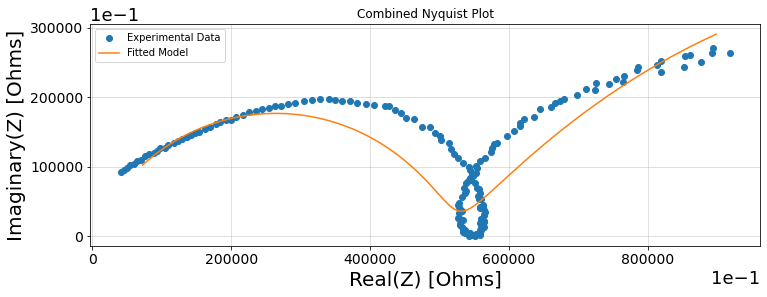

Fitted Parameters: [1.34578257e+02 5.24830454e-10 7.55399141e-01 5.18516424e+04
 2.14346131e-06 5.47754310e-01 1.03343680e+05 1.71593448e+04
 8.06599691e+04]


<Figure size 432x288 with 0 Axes>

In [32]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from impedance import preprocessing
from impedance.models.circuits import CustomCircuit
from impedance.visualization import plot_nyquist

# Function to clean data (removing NaNs and Infs)
def clean_data(frequencies, Z):
    mask = ~np.isnan(Z) & ~np.isinf(Z)
    return frequencies[mask], Z[mask]

frequencies, Z = preprocessing.readCSV('50.csv')

frequencies, Z = clean_data(frequencies, Z)


circuit_str = 'R_0 - p(CPE_1,R_1) - p(CPE_2,R_2 - p(L_3, R_3))'
initial_guess =  [1.41496500e+02 ,1.09204944e-09 ,7.43884442e-01 ,5.28066010e+04, 3.98454738e-06 ,7.59878844e-01 ,2.65004455e+05 ,6.75767880e+04, 2.02756599e+05] # Adjusted initial guesses

circuit = CustomCircuit(circuit=circuit_str, initial_guess=initial_guess)


circuit.fit(frequencies, Z)

# Predict the fitted data
Z_fit = circuit.predict(frequencies)

# Combine both graphs in one
plt.figure(figsize=(12, 8))  # Bigger graph for better visualization


plot_nyquist(Z, fmt='o', scale=10, ax=plt.gca(), label='Experimental Data')

plot_nyquist(Z_fit, fmt='-', scale=10, ax=plt.gca(), label='Fitted Model')

plt.legend()
plt.title('Combined Nyquist Plot')
plt.xlabel('Real(Z) [Ohms]')
plt.ylabel('Imaginary(Z) [Ohms]')
plt.grid(True)
plt.show()


print("Fitted Parameters:", circuit.parameters_)


np.savetxt('fitted_parameters.csv', circuit.parameters_, delimiter=',', 
           header='R0,CPE1_Q,CPE1_alpha,R1,CPE2_Q,CPE2_alpha,R2,Wo1_0,Wo1_1', 
           comments='')


plt.savefig('combined_nyquist_plot.png', dpi=300)

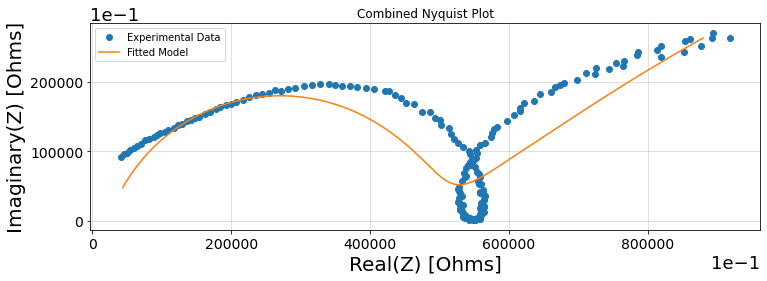

Fitted Parameters: [2.20501093e+03 6.21948630e-10 8.08066399e-01 4.72549528e+04
 3.54843207e-06 4.42623981e-01 3.22682756e+05 2.76036336e+02
 2.42500441e+05]


<Figure size 432x288 with 0 Axes>

In [112]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from impedance import preprocessing
from impedance.models.circuits import CustomCircuit
from impedance.visualization import plot_nyquist

# Function to clean data (removing NaNs and Infs)
def clean_data(frequencies, Z):
    mask = ~np.isnan(Z) & ~np.isinf(Z)
    return frequencies[mask], Z[mask]

frequencies, Z = preprocessing.readCSV('50.csv')

frequencies, Z = clean_data(frequencies, Z)


circuit_str = 'R_0 - p(CPE_1,R_1) - p(CPE_2,R_2 - p(L_3, R_3))'
initial_guess =   [5.90383086e+01, 6.83438971e-10, 7.53300859e-01, 1.13807139e+03 , 9.97690033e-06 ,4.26260989e-01,2.30213997e+05,4.28394116e+01 ,1.22365084e+05]# Adjusted initial guesses

circuit = CustomCircuit(circuit=circuit_str, initial_guess=initial_guess)


circuit.fit(frequencies, Z)

# Predict the fitted data
Z_fit = circuit.predict(frequencies)

# Combine both graphs in one
plt.figure(figsize=(12, 8))  # Bigger graph for better visualization


plot_nyquist(Z, fmt='o', scale=10, ax=plt.gca(), label='Experimental Data')

plot_nyquist(Z_fit, fmt='-', scale=10, ax=plt.gca(), label='Fitted Model')

plt.legend()
plt.title('Combined Nyquist Plot')
plt.xlabel('Real(Z) [Ohms]')
plt.ylabel('Imaginary(Z) [Ohms]')
plt.grid(True)
plt.show()


print("Fitted Parameters:", circuit.parameters_)



plt.savefig('combined_nyquist_plot.png', dpi=300)

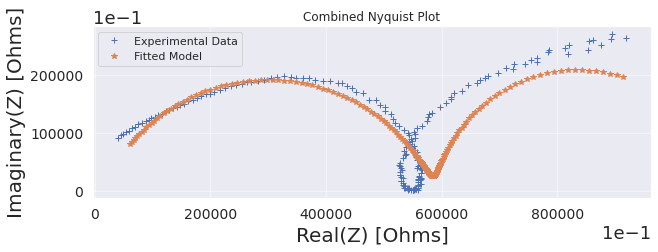

Fitted Parameters: [1.21504559e+03 5.76570552e+04 8.43259477e-10 7.45124849e-01
 4.96102823e+04 4.73924951e-07 8.87924832e-01]


<Figure size 432x288 with 0 Axes>

In [1]:
import numpy as np
from scipy.optimize import minimize
from impedance import preprocessing
from impedance.models.circuits import CustomCircuit
from impedance.visualization import plot_nyquist

# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn library

# Function to clean data (removing NaNs and Infs)
def clean_data(frequencies, Z):
    mask = ~np.isnan(Z) & ~np.isinf(Z)
    return frequencies[mask], Z[mask]
frequencies, Z = preprocessing.readCSV('50.csv')
frequencies, Z = clean_data(frequencies, Z)
circuit_str = 'R_0-p(R_1,CPE_1)-p(R_2,CPE_2)'
# initial_guess =[1.0e+04, 100000, 1.0, 0.5, 1.0e+5 , 100.0,  0.01] # Adjusted initial guesses
initial_guess = [4.08127359e+01,  5.10336218e+04, 1.33749422e-09, 7.20182283e-01, 0.95110848e+04, 1.37210091e-06, 9.20690396e-01]
circuit = CustomCircuit(circuit=circuit_str, initial_guess=initial_guess)
circuit.fit(frequencies, Z)
# Predict the fitted data
Z_fit = circuit.predict(frequencies)

# Combine both graphs in one
plt.figure(figsize=(10, 18))  # Bigger graph for better visualization

# Use seaborn to set the style
sns.set()

plot_nyquist(Z, fmt='+', scale=10, ax=plt.gca(), label='Experimental Data')

plot_nyquist(Z_fit, fmt='*', scale=10, ax=plt.gca(), label='Fitted Model')

plt.legend()
plt.title('Combined Nyquist Plot')
plt.xlabel('Real(Z) [Ohms]')
plt.ylabel('Imaginary(Z) [Ohms]')
plt.grid(True)
plt.show()


print("Fitted Parameters:", circuit.parameters_)



plt.savefig('combined_nyquist_plot.png', dpi=300)


In [2]:
import pandas as pd
from impedance import preprocessing
from impedance.models.circuits import Randles, CustomCircuit
import matplotlib.pyplot as plt
import numpy as np
from impedance.visualization import plot_nyquist
import seaborn as sns


# Load the input data
df = pd.read_csv('INPUT-DATA.csv')

# Filter and drop specific columns
df = df[df['Ionic radius '] != 2.060000e-10]
df = df.drop(columns=['Ionic radius '])
df = df[df['Temperature'] == 50]
df = df.drop(columns=['Temperature'])
df = df.drop(df.index[0])
#drop index column 
df = df.reset_index(drop=True)
df
#change the name of column Frequency to frequency
df.rename(columns={'Frequency': 'frequency'}, inplace=True)
#multiply last column by -1

df['Img(Z)'] = df['Img(Z)'] * -1
#save as 50.csv
df.to_csv('50(1).csv', index=False)  

In [30]:

# Load the data for fitting
frequencies, Z = preprocessing.readCSV('50(1).csv')
frequencies, Z = preprocessing.ignoreBelowX(frequencies, Z)
#remove NaN from Z
mask = ~np.isnan(Z)


# Check the content of frequencies and Z
print(f"frequencies: {frequencies}")
print(f"Z: {Z}")
print(f"Shape of frequencies: {frequencies.shape}")
print(f"Shape of Z: {Z.shape}")

# Fit the circuit
prediction = 0
if prediction == 0:
    customCircuit = CustomCircuit(
        initial_guess=[7.0e+04, 7.0e+04, 1.0e-06, 2.50e-01, 1.0e+05, 2.0e-09, 8.0e-01],
        circuit='R_0-p(R_1,CPE_1)-p(R_2,CPE_2)'
    )
else:
    customCircuit = CustomCircuit(
        initial_guess=[5.90383086e+01, 6.83438971e-10, 7.53300859e-01, 1.13807139e+03, 9.97690033e-06, 4.26260989e-01, 2.30213997e+05, 4.28394116e+01, 1.22365084e+05],
        circuit='R_0 - p(CPE_1,R_1) - p(CPE_2,R_2 - p(L_3, R_3))'
    )

# Fit the custom circuit
customCircuit.fit(frequencies, Z)

# Extract fitted values for plotting
Z_fit = customCircuit.predict(frequencies)
# Z_fit

# Convert Z and Z_fit to a DataFrame
Z_df = pd.DataFrame({'Re(Z)': np.real(Z), 'Img(Z)': -np.imag(Z)})
Z_fit_df = pd.DataFrame({'Re(Z)_fit': np.real(Z_fit), 'Img(Z)_fit': -np.imag(Z_fit)})

# Check the converted DataFrame
Z_df.to_csv('Z.csv', index=False)
Z_fit_df.to_csv('Z_fit.csv', index=False)


frequencies: [9.26e+05 8.58e+05 7.94e+05 7.36e+05 6.81e+05 6.31e+05 5.84e+05 5.41e+05
 5.01e+05 4.64e+05 4.30e+05 3.98e+05 3.69e+05 3.41e+05 3.16e+05 2.93e+05
 2.71e+05 2.51e+05 2.33e+05 2.15e+05 2.00e+05 1.85e+05 1.71e+05 1.58e+05
 1.47e+05 1.36e+05 1.26e+05 1.17e+05 1.08e+05 1.00e+05 9.26e+04 8.58e+04
 7.94e+04 7.36e+04 6.81e+04 6.31e+04 5.84e+04 5.41e+04 5.01e+04 4.64e+04
 4.30e+04 3.98e+04 3.69e+04 3.41e+04 3.16e+04 2.93e+04 2.71e+04 2.51e+04
 2.33e+04 2.15e+04 1.99e+04 1.85e+04 1.71e+04 1.58e+04 1.47e+04 1.36e+04
 1.26e+04 1.17e+04 1.08e+04 1.00e+04 9.26e+03 8.57e+03 7.94e+03 7.35e+03
 6.81e+03 6.31e+03 5.84e+03 5.41e+03 5.01e+03 4.64e+03 4.30e+03 3.98e+03
 3.69e+03 3.42e+03 3.16e+03 2.93e+03 2.71e+03 2.51e+03 2.33e+03 2.15e+03
 2.00e+03 1.85e+03 1.71e+03 1.58e+03 1.47e+03 1.36e+03 1.26e+03 1.17e+03
 1.08e+03 1.00e+03 9.26e+02 8.58e+02 7.94e+02 7.36e+02 6.81e+02 6.31e+02
 5.84e+02 5.41e+02 5.01e+02 4.64e+02 4.30e+02 3.98e+02 3.69e+02 3.41e+02
 3.16e+02 2.93e+02 2.71e+02 2.51e+02 2

      Re(Z)_fit   Img(Z)_fit
0  36239.485743  1620.988517
1  36271.756642  1726.014461
2  36306.942126  1839.662079
3  36343.880268  1958.020781
4  36384.477348  2087.005616


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

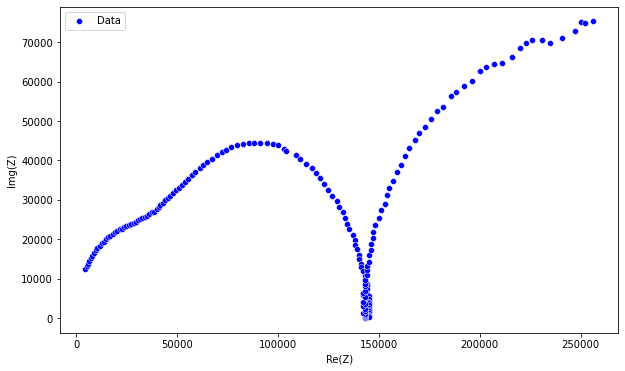

In [40]:

plot_data = pd.read_csv('Z.csv')
# Plot using Seaborn file Z_fit.csv
plot_data_fit = pd.read_csv('Z_fit.csv')
# plot_data

# Verify column names and inspect data
print(plot_data_fit.head())

# Adjust the plotting code to convert data to numpy arrays
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Re(Z)', y='Img(Z)', data=plot_data, label='Data', color='blue')
sns.lineplot(x=plot_data_fit['Re(Z)_fit'].values, y=plot_data_fit['Img(Z)_fit'].values, label='Fit', color='red')
plt.xlabel('Re(Z) [Ohm]')
plt.ylabel('-Imag(Z) [Ohm]')
plt.title('Nyquist Plot')
plt.legend()
plt.show()

print('Circuit Type', prediction)
print(customCircuit)


frequencies: [9.26e+05 8.58e+05 7.94e+05 7.36e+05 6.81e+05 6.31e+05 5.84e+05 5.41e+05
 5.01e+05 4.64e+05 4.30e+05 3.98e+05 3.69e+05 3.41e+05 3.16e+05 2.93e+05
 2.71e+05 2.51e+05 2.33e+05 2.15e+05 2.00e+05 1.85e+05 1.71e+05 1.58e+05
 1.47e+05 1.36e+05 1.26e+05 1.17e+05 1.08e+05 1.00e+05 9.26e+04 8.58e+04
 7.94e+04 7.36e+04 6.81e+04 6.31e+04 5.84e+04 5.41e+04 5.01e+04 4.64e+04
 4.30e+04 3.98e+04 3.69e+04 3.41e+04 3.16e+04 2.93e+04 2.71e+04 2.51e+04
 2.33e+04 2.15e+04 1.99e+04 1.85e+04 1.71e+04 1.58e+04 1.47e+04 1.36e+04
 1.26e+04 1.17e+04 1.08e+04 1.00e+04 9.26e+03 8.57e+03 7.94e+03 7.35e+03
 6.81e+03 6.31e+03 5.84e+03 5.41e+03 5.01e+03 4.64e+03 4.30e+03 3.98e+03
 3.69e+03 3.42e+03 3.16e+03 2.93e+03 2.71e+03 2.51e+03 2.33e+03 2.15e+03
 2.00e+03 1.85e+03 1.71e+03 1.58e+03 1.47e+03 1.36e+03 1.26e+03 1.17e+03
 1.08e+03 1.00e+03 9.26e+02 8.58e+02 7.94e+02 7.36e+02 6.81e+02 6.31e+02
 5.84e+02 5.41e+02 5.01e+02 4.64e+02 4.30e+02 3.98e+02 3.69e+02 3.41e+02
 3.16e+02 2.93e+02 2.71e+02 2.51e+02 2

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

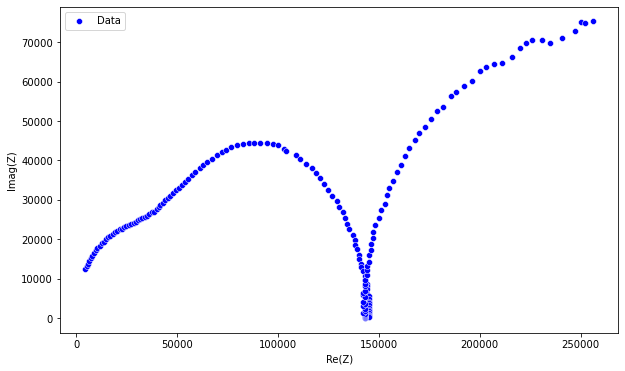

In [44]:
import pandas as pd
from impedance import preprocessing
from impedance.models.circuits import CustomCircuit
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Load the data for fitting
frequencies, Z = preprocessing.readCSV('50(1).csv')
frequencies, Z = preprocessing.ignoreBelowX(frequencies, Z)

# Remove NaN from Z
mask = ~np.isnan(Z)
frequencies = frequencies[mask]
Z = Z[mask]

# Check the content of frequencies and Z
print(f"frequencies: {frequencies}")
print(f"Z: {Z}")
print(f"Shape of frequencies: {frequencies.shape}")
print(f"Shape of Z: {Z.shape}")

# Fit the circuit
prediction = 0
if prediction == 0:
    customCircuit = CustomCircuit(
        initial_guess=[7.0e+04, 7.0e+04, 1.0e-06, 2.50e-01, 1.0e+05, 2.0e-09, 8.0e-01],
        circuit='R_0-p(R_1,CPE_1)-p(R_2,CPE_2)'
    )
else:
    customCircuit = CustomCircuit(
        initial_guess=[5.90383086e+01, 6.83438971e-10, 7.53300859e-01, 1.13807139e+03, 9.97690033e-06, 4.26260989e-01, 2.30213997e+05, 4.28394116e+01, 1.22365084e+05],
        circuit='R_0 - p(CPE_1,R_1) - p(CPE_2,R_2 - p(L_3, R_3))'
    )

# Fit the custom circuit
customCircuit.fit(frequencies, Z)

# Extract fitted values for plotting
Z_fit = customCircuit.predict(frequencies)

# Create a DataFrame for Seaborn
plot_data = pd.DataFrame({
    'Re(Z)': np.real(Z),
    'Imag(Z)': -np.imag(Z),
    'Re(Z)_fit': np.real(Z_fit),
    'Imag(Z)_fit': -np.imag(Z_fit)
})

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Re(Z)', y='Imag(Z)', data=plot_data, label='Data', color='blue')
sns.lineplot(x='Re(Z)_fit', y='Imag(Z)_fit', data=plot_data_fit, label='Fit', color='red')
plt.xlabel('Re(Z) [Ohm]')
plt.ylabel('-Imag(Z) [Ohm]')
plt.title('Nyquist Plot')
plt.legend()
plt.show()

print('Circuit Type', prediction)
print(customCircuit)
